In [1]:
# Downgrade pip and numpy first
%pip install pip==23.2.1 numpy==1.23.5 --force-reinstall




  Obtaining dependency information for pip==23.2.1 from https://files.pythonhosted.org/packages/50/c2/e06851e8cc28dcad7c155f4753da8833ac06a5c704c109313b8d5a62968a/pip-23.2.1-py3-none-any.whl.metadata
  Using cached pip-23.2.1-py3-none-any.whl.metadata (4.2 kB)
  Obtaining dependency information for numpy==1.23.5 from https://files.pythonhosted.org/packages/e8/ad/b935c7421657a032fd2a5332eed098f3b9993a155afceb1daa280ff6611f/numpy-1.23.5-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
  Using cached numpy-1.23.5-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (2.3 kB)
Using cached pip-23.2.1-py3-none-any.whl (2.1 MB)
Using cached numpy-1.23.5-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (17.1 MB)
  Attempting uninstall: pip
    Found existing installation: pip 23.2.1
    Uninstalling pip-23.2.1:
      Successfully uninstalled pip-23.2.1
  Attempting uninstall: numpy
    Found existing installation: numpy 1.23.5
    Uninstalling numpy-1

In [1]:
# 2. Restart the runtime manually (from menu: Runtime > Restart Runtime)

# 3. After restart, install specific versions of GluonTS and MXNet
%pip install mxnet==1.7.0.post2 gluonts==0.10.3 matplotlib pandas --no-cache-dir

  Obtaining dependency information for mxnet==1.7.0.post2 from https://files.pythonhosted.org/packages/64/20/76af36cad6754a15f39d3bff19e09921dec72b85261e455d4edc50ebffa8/mxnet-1.7.0.post2-py2.py3-none-manylinux2014_x86_64.whl.metadata
  Obtaining dependency information for gluonts==0.10.3 from https://files.pythonhosted.org/packages/b2/99/95296731159d619e0cb9bf3344bc4534e88a4d1db244af74b8aba51e0ff3/gluonts-0.10.3-py3-none-any.whl.metadata
  Obtaining dependency information for graphviz<0.9.0,>=0.8.1 from https://files.pythonhosted.org/packages/53/39/4ab213673844e0c004bed8a0781a0721a3f6bb23eb8854ee75c236428892/graphviz-0.8.4-py2.py3-none-any.whl.metadata
  Obtaining dependency information for pandas from https://files.pythonhosted.org/packages/56/73/3351beeb807dca69fcc3c4966bcccc51552bd01549a9b13c04ab00a43f21/pandas-1.5.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
  Obtaining dependency information for pydantic~=1.7 from https://files.pythonhosted.org/packages/a

Running evaluation: 100%|██████████| 1/1 [00:00<00:00, 30.74it/s]



Backtest Evaluation Metrics:
MSE                           : 639.1646
abs_error                     : 257.9651
abs_target_sum                : 10352.0000
abs_target_mean               : 862.6667
seasonal_error                : 22.2361
MASE                          : 0.9668
MAPE                          : 0.0243
sMAPE                         : 0.0239
MSIS                          : 6.4750
QuantileLoss[0.1]             : 106.1577
Coverage[0.1]                 : 0.3333
QuantileLoss[0.2]             : 192.0199
Coverage[0.2]                 : 0.5833
QuantileLoss[0.3]             : 248.9761
Coverage[0.3]                 : 0.6667
QuantileLoss[0.4]             : 264.7613
Coverage[0.4]                 : 0.7500
QuantileLoss[0.5]             : 257.9651
Coverage[0.5]                 : 0.7500
QuantileLoss[0.6]             : 232.0992
Coverage[0.6]                 : 0.8333
QuantileLoss[0.7]             : 203.4407
Coverage[0.7]                 : 1.0000
QuantileLoss[0.8]             : 162.5351
Coverag

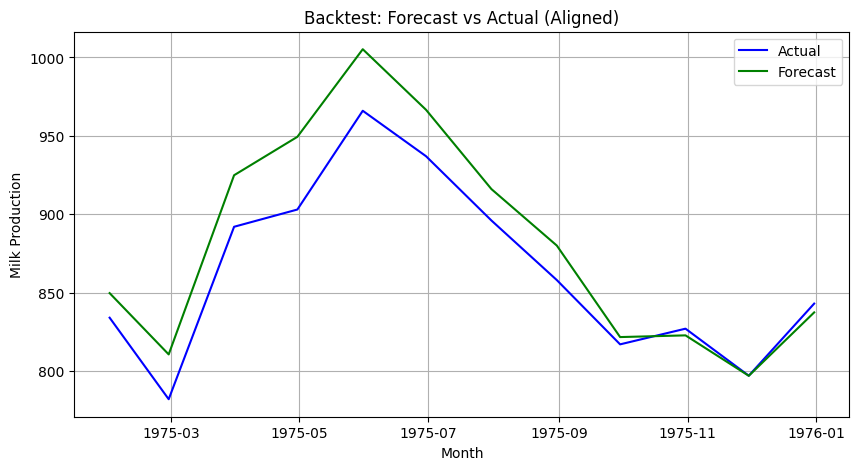


📋 Forecast vs Actual:
    Timestamp  Actual    Predicted
0  1975-01-31   834.0   849.684753
1  1975-02-28   782.0   810.581970
2  1975-03-31   892.0   924.875793
3  1975-04-30   903.0   949.379639
4  1975-05-31   966.0  1005.258362
5  1975-06-30   937.0   966.609863
6  1975-07-31   896.0   916.035645
7  1975-08-31   858.0   880.008911
8  1975-09-30   817.0   821.643372
9  1975-10-31   827.0   822.732239
10 1975-11-30   797.0   796.935608
11 1975-12-31   843.0   837.379944


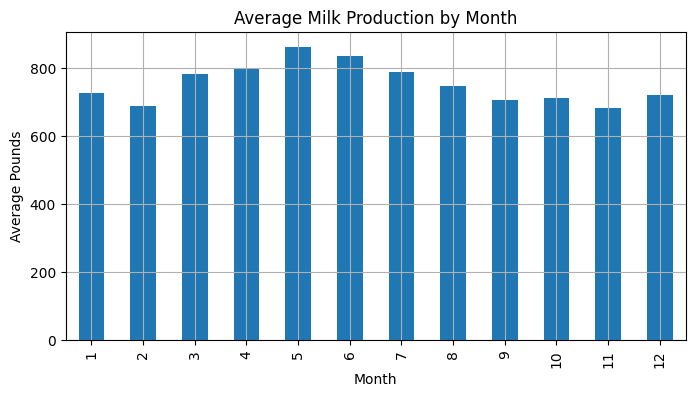

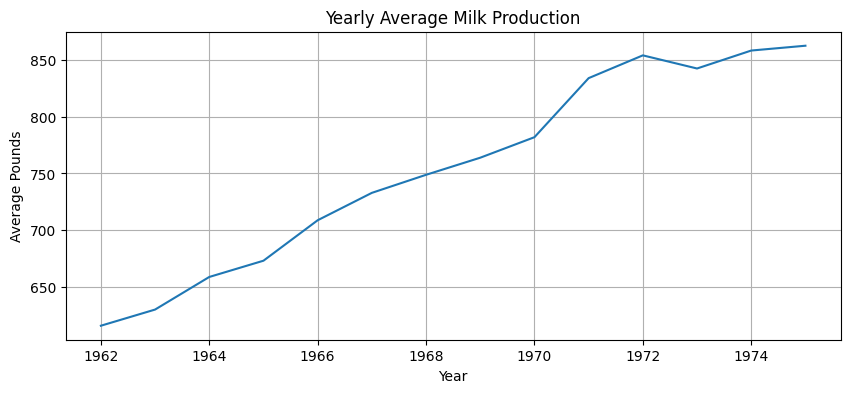

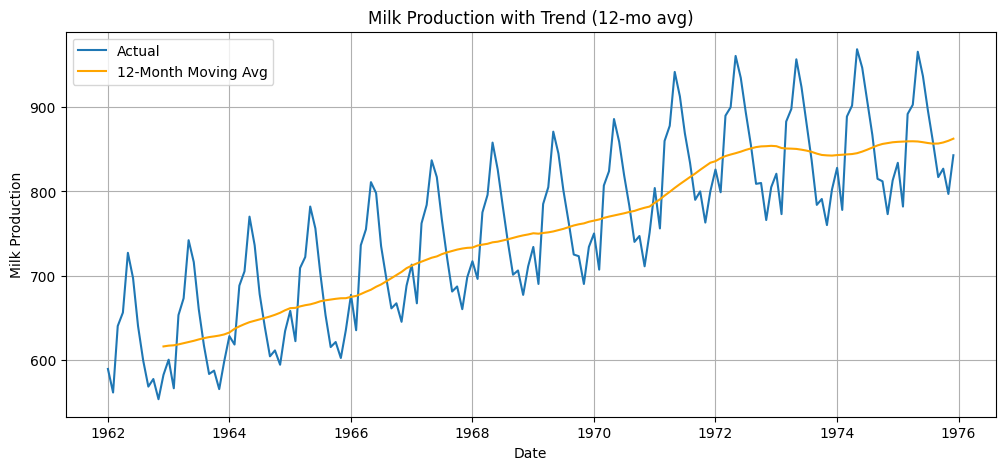

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from gluonts.dataset.common import ListDataset
from gluonts.model.deepar import DeepAREstimator
from gluonts.mx.trainer import Trainer
from gluonts.evaluation.backtest import make_evaluation_predictions
from gluonts.evaluation import Evaluator

# Load your dataset
df = pd.read_csv("/monthly-milk-production-pounds.csv")
df.columns = ['timestamp', 'value']  # Rename to match expected names
df['timestamp'] = pd.to_datetime(df['timestamp'])

# --- BACKTEST SETUP ---
prediction_length = 12
cutoff_index = len(df) - prediction_length
train_df = df.iloc[:cutoff_index]


training_data = ListDataset(
    [{
        "start": train_df['timestamp'].iloc[0],
        "target": train_df['value'].values
    }],
    freq="M"
)

test_data = ListDataset(
    [{
        "start": df['timestamp'].iloc[0],
        "target": df['value'].values
    }],
    freq="M"
)


# --- Train DeepAR Model ---
estimator = DeepAREstimator(
    prediction_length=prediction_length,
    freq="M",
    trainer=Trainer(epochs=10)
)
predictor = estimator.train(training_data=training_data)

# --- Generate Forecast ---
forecast_it, ts_it = make_evaluation_predictions(
    dataset=test_data,
    predictor=predictor,
    num_samples=100
)

forecasts = list(forecast_it)
tss = list(ts_it)

# --- Extract values and timestamps ---
forecast = forecasts[0]
actual_values = tss[0][-prediction_length:].values.flatten()
predicted_means = forecast.mean.flatten()
forecast_index = pd.date_range(
    start=forecast.start_date.to_timestamp(),
    periods=prediction_length,
    freq="M"
)

# --- Evaluation Metrics ---
evaluator = Evaluator()
agg_metrics, _ = evaluator(tss, forecasts, num_series=len(tss))

print("\nBacktest Evaluation Metrics:")
for key, value in agg_metrics.items():
    print(f"{key:30s}: {value:.4f}")

# --- Plot actual vs forecast ---
plt.figure(figsize=(10, 5))
plt.plot(forecast_index, actual_values, label="Actual", color='blue')
plt.plot(forecast_index, predicted_means, label="Forecast", color='green')
plt.title("Backtest: Forecast vs Actual (Aligned)")
plt.xlabel("Month")
plt.ylabel("Milk Production")
plt.legend()
plt.grid(True)
plt.show()

# --- Tabular comparison ---
comparison_df = pd.DataFrame({
    "Timestamp": forecast_index,
    "Actual": actual_values,
    "Predicted": predicted_means
})
print("\n📋 Forecast vs Actual:")
print(comparison_df)


# --- Optional: Export to CSV ---
comparison_df.to_csv("forecast_vs_actual.csv", index=False)

# === SEASONAL PATTERN ANALYSIS ===

# -- Monthly trend over all years
df['Month'] = df['timestamp'].dt.month
monthly_avg = df.groupby('Month')['value'].mean()

plt.figure(figsize=(8,4))
monthly_avg.plot(kind='bar')
plt.title("Average Milk Production by Month")
plt.xlabel("Month")
plt.ylabel("Average Pounds")
plt.grid(True)
plt.show()

# -- Yearly trend
df['Year'] = df['timestamp'].dt.year
yearly_avg = df.groupby('Year')['value'].mean()

plt.figure(figsize=(10,4))
yearly_avg.plot()
plt.title("Yearly Average Milk Production")
plt.xlabel("Year")
plt.ylabel("Average Pounds")
plt.grid(True)
plt.show()

# -- Moving average for trend smoothing
df['RollingMean'] = df['value'].rolling(window=12).mean()

plt.figure(figsize=(12,5))
plt.plot(df['timestamp'], df['value'], label='Actual')
plt.plot(df['timestamp'], df['RollingMean'], color='orange', label='12-Month Moving Avg')
plt.title("Milk Production with Trend (12-mo avg)")
plt.xlabel("Date")
plt.ylabel("Milk Production")
plt.legend()
plt.grid(True)
plt.show()


🧠 Months ranked by average milk production:
 Month
5     862.785714
6     836.142857
4     800.071429
7     788.071429
3     783.500000
8     747.500000
1     727.071429
12    721.000000
10    711.857143
9     706.642857
2     689.285714
11    682.571429
Name: value, dtype: float64


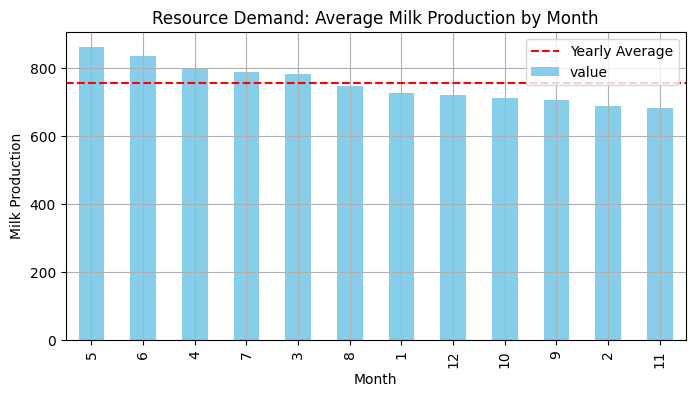

In [3]:
#Seasonality-Driven Resource Allocation
df['Month'] = df['timestamp'].dt.month
monthly_avg = df.groupby('Month')['value'].mean().sort_values(ascending=False)
print("🧠 Months ranked by average milk production:\n", monthly_avg)

#Peak Load Identification
plt.figure(figsize=(8,4))
monthly_avg.plot(kind='bar', color='skyblue')
plt.axhline(monthly_avg.mean(), color='red', linestyle='--', label='Yearly Average')
plt.title("Resource Demand: Average Milk Production by Month")
plt.ylabel("Milk Production")
plt.legend()
plt.grid(True)
plt.show()

📦 Forecasted high-demand months:
 Month
5     1005.258362
6      966.609863
4      949.379639
3      924.875793
7      916.035645
8      880.008911
1      849.684753
12     837.379944
10     822.732239
9      821.643372
2      810.581970
11     796.935608
Name: Predicted, dtype: float32


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


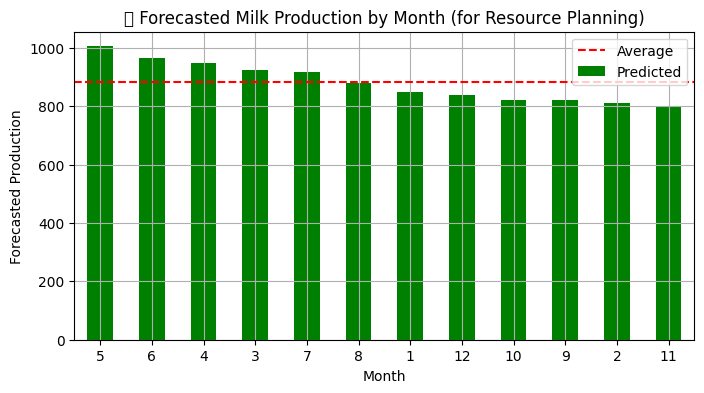

In [4]:
#Forecast Resource Needs Based on Projections

#Using my DeepAR forecast results to anticipate the next year's peaks:
comparison_df["Month"] = comparison_df["Timestamp"].dt.month
forecast_by_month = comparison_df.groupby("Month")["Predicted"].mean().sort_values(ascending=False)
print("📦 Forecasted high-demand months:\n", forecast_by_month)


# --- Plot forecasted milk production by month ---
plt.figure(figsize=(8,4))
forecast_by_month.plot(kind='bar', color='green')
plt.axhline(forecast_by_month.mean(), color='red', linestyle='--', label='Average')
plt.title("📦 Forecasted Milk Production by Month (for Resource Planning)")
plt.xlabel("Month")
plt.ylabel("Forecasted Production")
plt.grid(True)
plt.legend()
plt.xticks(rotation=0)
plt.show()


📊 Resource Planning Dashboard:

       Forecasted Milk (lbs)  Resource Demand Score (0-100)  \
Month                                                         
1                 849.679993                      25.299999   
2                 810.580017                       6.600000   
3                 924.880005                      61.400002   
4                 949.380005                      73.199997   
5                1005.260010                     100.000000   
6                 966.609985                      81.400002   
7                 916.039978                      57.200001   
8                 880.010010                      39.900002   
9                 821.640015                      11.900000   
10                822.729980                      12.400000   
11                796.940002                       0.000000   
12                837.380005                      19.400000   

       Estimated Truck Trips  
Month                         
1                     

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


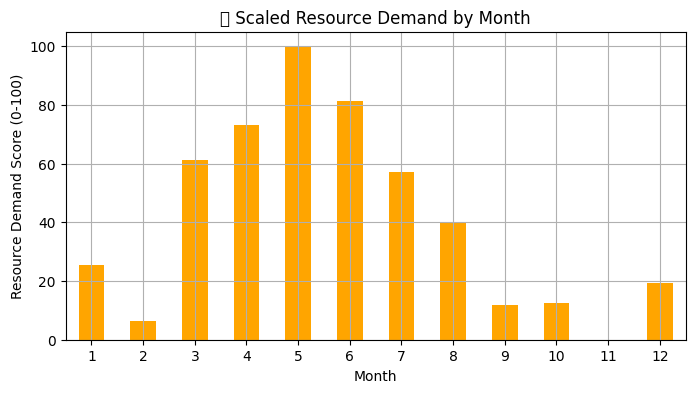

In [6]:
#Resource Planning Dashboard
import numpy as np

# Forecast by month
# Group forecast by month
comparison_df["Month"] = comparison_df["Timestamp"].dt.month
forecast_by_month = comparison_df.groupby("Month")["Predicted"].mean()

# 1. 📦 Resource Demand Score (0–100 scale)
# You can use Min-Max scaling to normalize demand
min_val = forecast_by_month.min()
max_val = forecast_by_month.max()
resource_score = ((forecast_by_month - min_val) / (max_val - min_val)) * 100

# 2. 🚚 Estimate transport load (e.g., 1 truck carries 500 units)
truck_capacity = 500
transport_trips = (forecast_by_month / truck_capacity).apply(np.ceil)

# 3. Combine into a dashboard table
dashboard_df = pd.DataFrame({
    "Forecasted Milk (lbs)": forecast_by_month.round(2),
    "Resource Demand Score (0-100)": resource_score.round(1),
    "Estimated Truck Trips": transport_trips.astype(int)
})

# Print dashboard
print("\n📊 Resource Planning Dashboard:\n")
print(dashboard_df)

# Optional: Save to CSV
dashboard_df.to_csv("resource_planning_dashboard.csv")

# Plot Resource Demand Score
plt.figure(figsize=(8,4))
resource_score.plot(kind='bar', color='orange')
plt.title("📦 Scaled Resource Demand by Month")
plt.ylabel("Resource Demand Score (0-100)")
plt.xlabel("Month")
plt.grid(True)
plt.xticks(rotation=0)
plt.show()

